# Notebook to create train & test set of images

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
sys.path.append('scripts/')
import numpy as np
import matplotlib.pyplot as plt
import rasterio, rasterio.plot
import xarray as xr
import rioxarray as rxr
from tqdm import tqdm
import pandas as pd
import geopandas as gpd
import loadpaths
import land_cover_analysis as lca
import land_cover_visualisation as lcv


path_dict = loadpaths.loadpaths()

## Create shape file of list of tile names

In [4]:
## Get list of tile names from text file:
with open('/home/tplas/repos/cnn-land-cover/content/tiles_few_changes/tiles_few_changes_list.txt', 'r') as f:
    tiles_unchanged = f.readlines()
tiles_unchanged = [x.rstrip('\n') for x in tiles_unchanged]

In [5]:
## Select tiles by name & save as new shp file
tmp = lca.select_tiles_from_list(list_tile_names=tiles_unchanged, 
                                 save_new_shp=False,
                                 new_shp_filename='content/tiles_few_changes/tiles_few_changes')

## Get distribution of classes of tiles from shp

In [3]:
## LC polygons:
df_lc_80s, mapping_class_inds = lca.load_landcover(pol_path=os.path.join(path_dict['lc_80s_path']))

Text(0.5, 1.0, 'Distribution of LC of entire PD')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


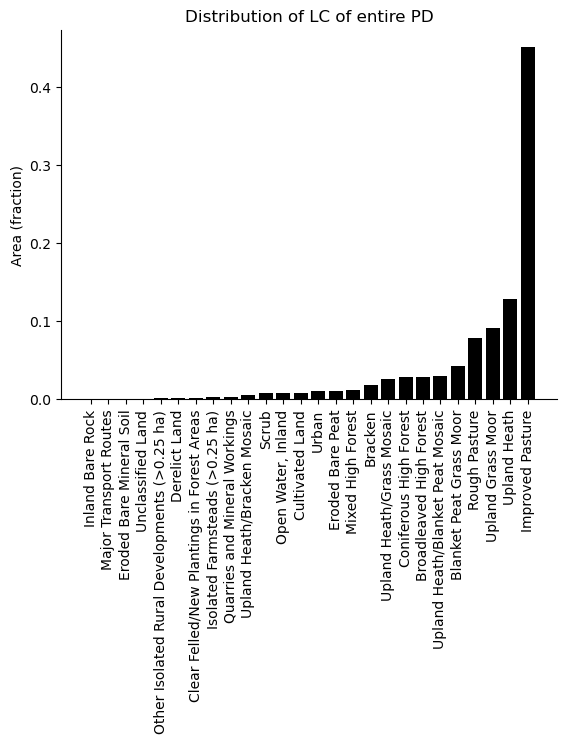

In [7]:
ax_distr, _ = lcv.plot_distr_classes_from_shape(df_lc=df_lc_80s)
ax_distr.set_title('Distribution of LC of entire PD')

## Process all tiles:

In [7]:
## Instead, we can use the existing shp file:
df_all_tiles = lca.get_shp_all_tiles()
# df_all_tiles = df_all_tiles.iloc[np.random.choice(a=2125, size=100, replace=False)]

In [8]:
## Get LC polygons for each tile, for all tiles:
dict_intersect_pols_all_tiles = lca.get_pols_for_tiles(df_pols=df_lc_80s, df_tiles=df_all_tiles, col_name='PLAN_NO')

100%|██████████| 2125/2125 [02:06<00:00, 16.74it/s]


In [9]:
## Calculate distribution of classes for each tile:
df_class_distr = lca.create_df_with_class_distr_per_tile(dict_dfs=dict_intersect_pols_all_tiles, 
                                                         all_class_names=list(df_lc_80s['LC_D_80'].unique()),
                                                         no_class_threshold=0.05)
df_all_tiles = df_all_tiles[np.isin(df_all_tiles['PLAN_NO'], df_class_distr['tile_name'])]
assert len(df_all_tiles) == len(df_class_distr)

2125it [00:05, 402.31it/s]


2125 tiles analysed
777 tiles kept after no-class filter


## Get sample:

In [22]:
inds_tiles, df_lc_sample = lca.sample_tiles_by_class_distr_from_df(df_all_tiles_distr=df_class_distr, 
                                              n_samples=50, iterations=10000)

At it 1 new loss of 0.21011430906624792
At it 4 new loss of 0.16886366918418894
At it 21 new loss of 0.14422196370163337
At it 24 new loss of 0.12795144956564192
At it 30 new loss of 0.11049091022866078
At it 102 new loss of 0.1056856072994414
At it 338 new loss of 0.10440951927394859
At it 399 new loss of 0.10041935219587056
At it 445 new loss of 0.08708487807389619
At it 1942 new loss of 0.08682303526108687
At it 4646 new loss of 0.08586026372985761
At it 6318 new loss of 0.08137704573844867
At it 6494 new loss of 0.08072061114425122
At it 7479 new loss of 0.07104736705894367
At it 7784 new loss of 0.06638531728842595


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


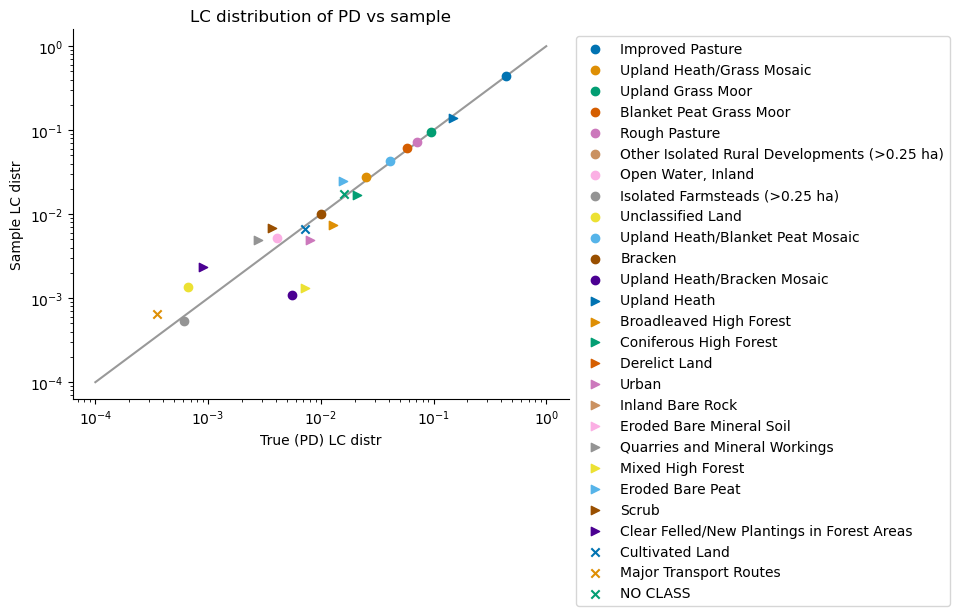

In [10]:
lcv.plot_scatter_class_distr_two_dfs(df_1=df_class_distr, df_2=df_class_distr_sample, save_fig=False)

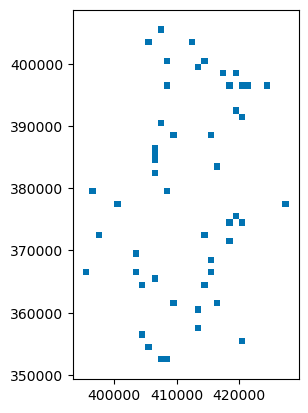

In [35]:
df_all_tiles.iloc[inds_tiles].plot()

In [39]:
df_tiles_sample = df_all_tiles.iloc[inds_tiles]
df_tiles_sample.to_file('content/evaluation_sample_50tiles/evaluation_sample_50tiles.shp')

### Load existing sample:

In [4]:
df_tiles_sample = gpd.read_file('content/evaluation_sample_50tiles/evaluation_sample_50tiles.shp')
## Get LC polygons for each tile, for all tiles:
dict_intersect_pols_sample_tiles = lca.get_pols_for_tiles(df_pols=df_lc_80s, df_tiles=df_tiles_sample, col_name='PLAN_NO')

100%|██████████| 50/50 [00:03<00:00, 15.07it/s]


In [5]:
## Calculate distribution of classes for each tile:
df_class_distr_sample = lca.create_df_with_class_distr_per_tile(dict_dfs=dict_intersect_pols_sample_tiles, 
                                                         all_class_names=list(df_lc_80s['LC_D_80'].unique()),
                                                         no_class_threshold=0.05)
assert len(df_class_distr_sample) == len(df_tiles_sample), 'no class filter deleted tiles => different filters must have been used'

50it [00:00, 339.69it/s]

50 tiles analysed
50 tiles kept after no-class filter


## Compare AREA column vs area calculation of polygon:

In [ ]:
# np.isclose(df_lc_80s['AREA'], df_lc_80s['geometry'].area).sum()
# 
plt.plot(df_lc_80s['AREA'], df_lc_80s['geometry'].area, '.')
plt.xlabel('Reported Area')
plt.ylabel('Polygon area')
print(np.where(np.abs(df_lc_80s['AREA'] - df_lc_80s['geometry'].area) > 1e4)[0])

In [ ]:
# i_pol = 37
# print(df_lc_80s.iloc[i_pol])
for i_pol in np.where(np.abs(df_lc_80s['AREA'] - df_lc_80s['geometry'].area) > 1e2)[0]:
    print(i_pol, df_lc_80s.iloc[i_pol]['LC_D_80'])
    print(f'Area of pol is {df_lc_80s.iloc[i_pol]["geometry"].area / 1e6} km^2, but DF says {df_lc_80s.iloc[i_pol]["AREA"] / 1e6}')


In [ ]:
df_lc_80s['AREA'].max() / 1e6

In [ ]:
print(f'Total area according to DF is {df_lc_80s["AREA"].sum() / 1e6} km^2 but according to pol {df_lc_80s["geometry"].area.sum() / 1e6} km^2')

In [ ]:
ax_distr, _ = lcv.plot_distr_classes_from_shape(df_lc=df_lc_80s)
ax_distr.set_title('Distribution of LC of entire PD')